In [345]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [346]:
grains = pd.read_csv('datasets/seeds.csv')

In [347]:
grains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               210 non-null    float64
 1   1               210 non-null    float64
 2   2               210 non-null    float64
 3   3               210 non-null    float64
 4   4               210 non-null    float64
 5   5               210 non-null    float64
 6   6               210 non-null    float64
 7   variety_number  210 non-null    int64  
 8   variety         210 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB


In [348]:
grains

,0,1,2,3,4,5,6,variety_number,variety
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat
...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3,Canadian wheat
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3,Canadian wheat
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3,Canadian wheat
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3,Canadian wheat


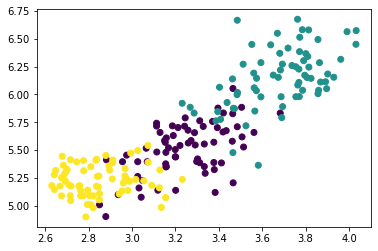

In [349]:
#Width vs Length
plt.scatter(grains['4'], grains['3'], c=grains['variety_number'])

In [350]:
X = grains.drop(['variety', 'variety_number'], axis=1).values

KMeans Method

Text(0.5, 0, 'K-clusters')

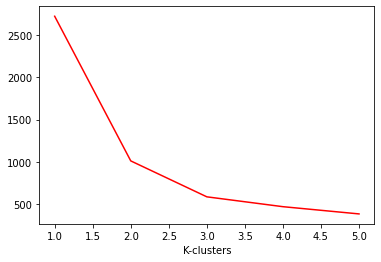

In [351]:
from sklearn.cluster import KMeans

inertias = list()
ks = list(range(1,6))

for k in ks:
    model = KMeans(n_clusters= k)
    model.fit(X)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-r')
plt.xlabel('K-clusters')



In [352]:
def getDeltas(y_,x_):
    #calculate slopes this might seem confusing but its just a list compression of deltaY/deltaX
    return [(val[0] - y_[i]) / (val[1] - x_[i]) for i, val in enumerate(zip(y_[1:], x_[1:]))]

In [353]:
firstOrd = getDeltas(inertias, ks)
secondOrd = getDeltas(firstOrd,ks)
print(ks)
print(inertias)
print(firstOrd)
print(secondOrd)

[1, 2, 3, 4, 5]
[2719.852410177952, 1011.7123453151189, 587.3186115940426, 471.00339552519216, 385.5821219997564]
[-1708.1400648628332, -424.3937337210763, -116.31521606885048, -85.42127352543577]
[1283.7463311417569, 308.0785176522258, 30.89394254341471]


In [354]:
#K = 3 appears to be the best as the rate of change of the slope starts to approach 0 starting at 3 to 4
model = KMeans(n_clusters=3, random_state= 63)
labels = model.fit_predict(X)
varieties = grains['variety']
df = pd.DataFrame({'labels':labels, 'varieties':varieties})
ct = pd.crosstab(df['labels'], df['varieties'])

In [355]:
#Looks like there are couple errors, lets try preprocessing the data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
pipeline = make_pipeline(scaler, model)
labelscaled = pipeline.fit_predict(X)
df = pd.DataFrame({'labels':labelscaled, 'varieties':varieties})
ctscaled = pd.crosstab(df['labels'], df['varieties'])
print(f'Unscaled:\n{ct}\n\nScaled:\n{ctscaled}')



Unscaled:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           1          60
1                      68           9           0
2                       2          60          10

Scaled:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       4          62           5
1                       0           2          65
2                      66           6           0


Text(0, 0.5, 'Length')

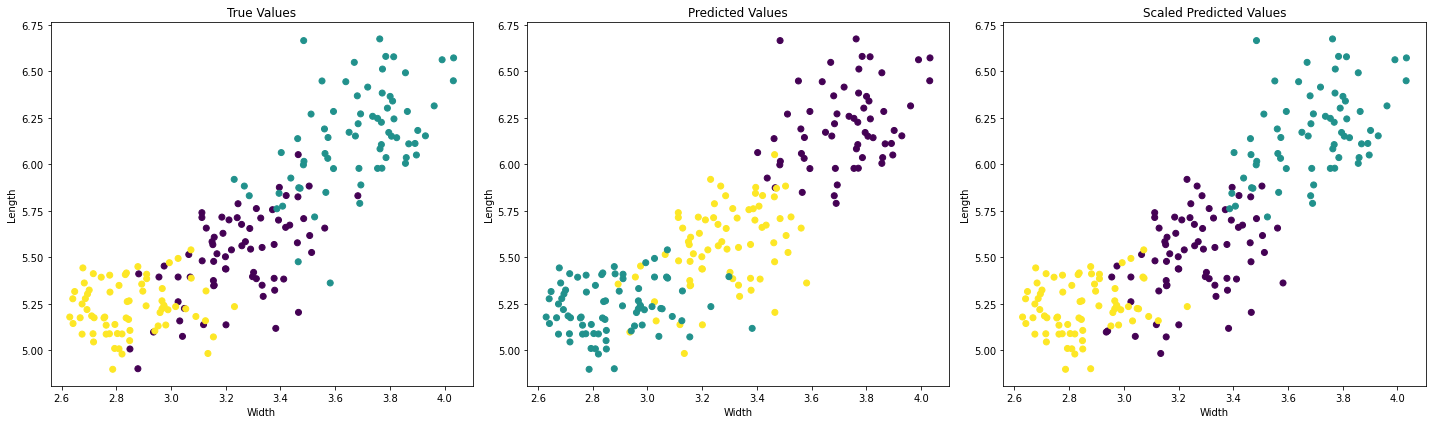

In [356]:
#Actual Scatter vs Predicted Scatter
fig = plt.figure(figsize=(20, 6), tight_layout = True)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(X[:, 4], X[:, 3], c=grains['variety_number'])
ax1.set_title('True Values')
ax1.set_xlabel('Width')
ax1.set_ylabel('Length')

ax2.scatter(X[:, 4], X[:, 3], c=labels)
ax2.set_title('Predicted Values')
ax2.set_xlabel('Width')
ax2.set_ylabel('Length')

ax3.scatter(X[:, 4], X[:, 3], c=labelscaled)
ax3.set_title('Scaled Predicted Values')
ax3.set_xlabel('Width')
ax3.set_ylabel('Length')

Hierarchical Clustering

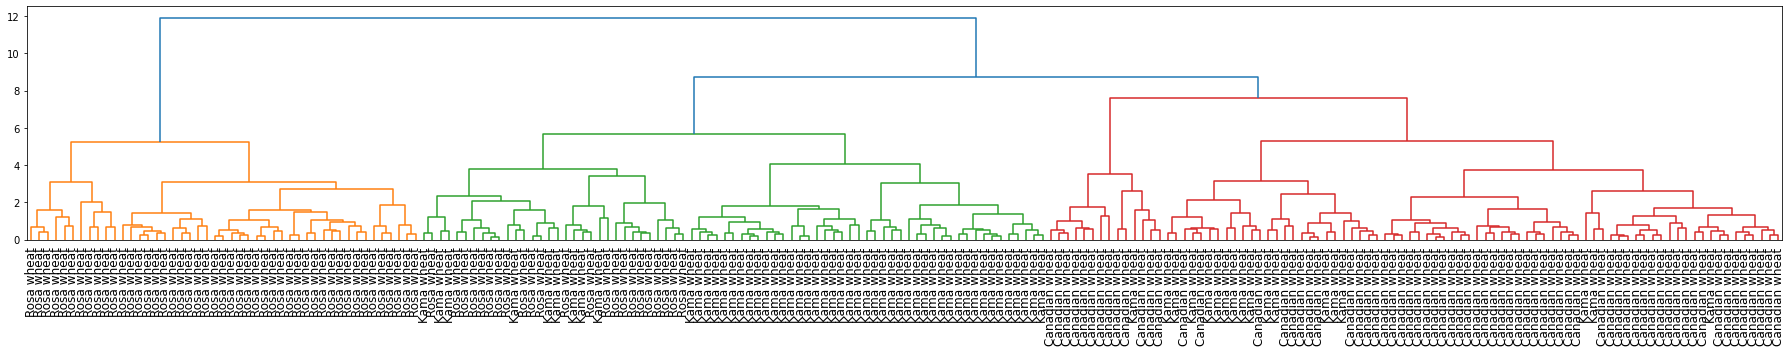

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,0,47
2,0,52,23
3,70,18,0


In [357]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
mergings = linkage(X, method='complete')
fig = plt.figure(figsize=(25, 5), tight_layout = True)

dendrogram(mergings, 
           labels = list(varieties), 
           leaf_rotation=90, 
           leaf_font_size=12)
plt.show()
labels = fcluster(mergings, 8, criterion= 'distance')
df = pd.DataFrame({'labels': labels, 'varieties': varieties})
ctcomplete = pd.crosstab(df['labels'], df['varieties'])
ctcomplete

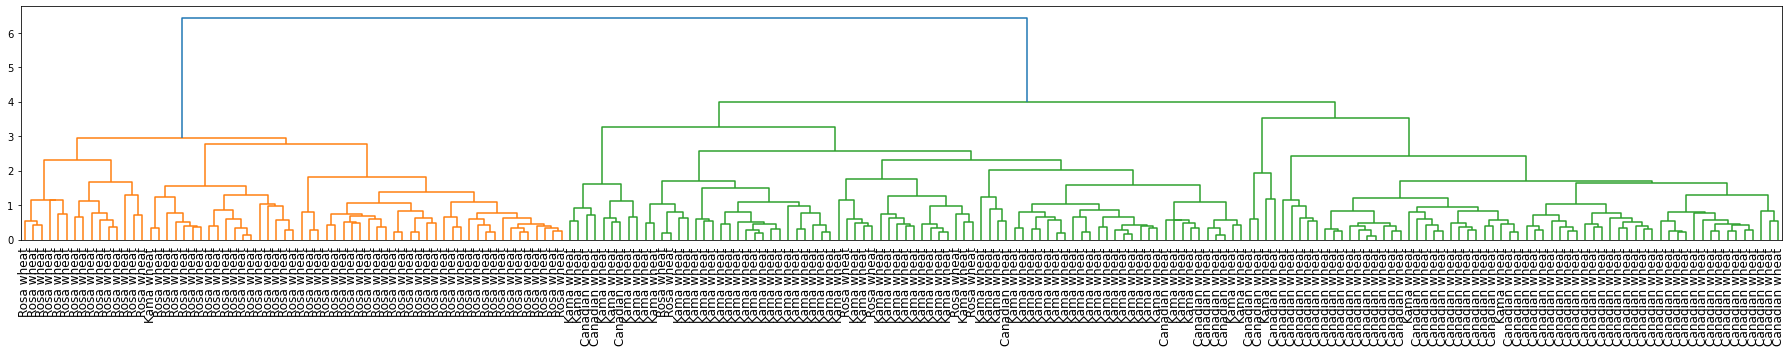

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,1,64
2,9,66,6
3,61,3,0


In [358]:
mergings = linkage(X, method='average')
fig = plt.figure(figsize=(25, 5), tight_layout = True)
dendrogram(mergings, 
           labels = list(grains['variety']), 
           leaf_rotation=90, 
           leaf_font_size=12)
plt.show()
labels = fcluster(mergings, 4, criterion= 'distance')
df = pd.DataFrame({'labels': labels, 'varieties': varieties})
ctavg = pd.crosstab(df['labels'], df['varieties'])
ctavg

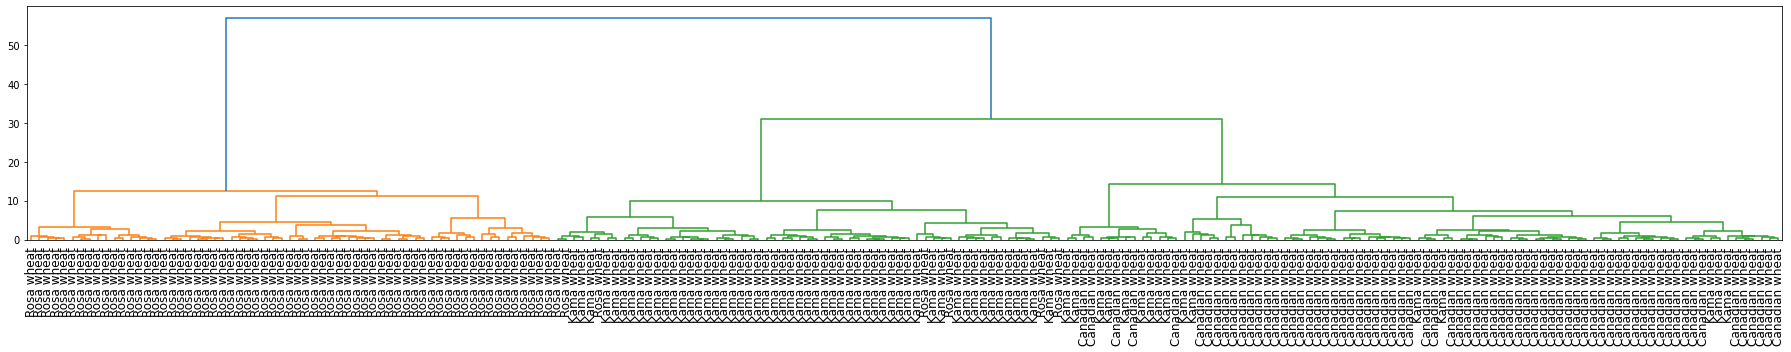

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,0,63
2,0,54,7
3,70,16,0


In [359]:
mergings = linkage(X, method='ward')
fig = plt.figure(figsize=(25, 5), tight_layout = True)
dendrogram(mergings, 
           labels = list(grains['variety']), 
           leaf_rotation=90, 
           leaf_font_size=12)
plt.show()

labels = fcluster(mergings, 20, criterion= 'distance')
df = pd.DataFrame({'labels': labels, 'varieties': varieties})
ctward = pd.crosstab(df['labels'], df['varieties'])
ctward

In [360]:
print(f'Complete Linkage:\n{ctcomplete}\n\nAverage Linkage:\n{ctavg}\n\nWard Linkage:\n{ctward}')
#looks like the best one is average linkage

Complete Linkage:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           0          47
2                       0          52          23
3                      70          18           0

Average Linkage:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           1          64
2                       9          66           6
3                      61           3           0

Ward Linkage:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           0          63
2                       0          54           7
3                      70          16           0


t-SNE

C:\Users\mbk61\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


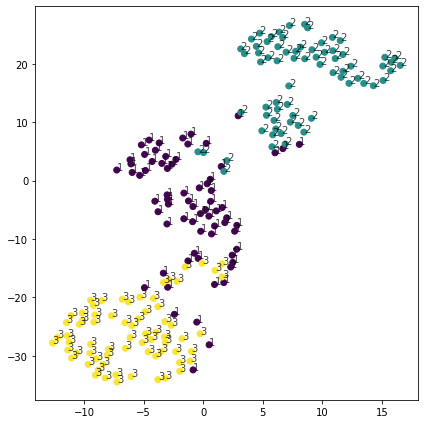

In [445]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate=430, perplexity= 20, n_iter= 5000)
tsne_features = model.fit_transform(X)

xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
fig = plt.figure(figsize=(6, 6), tight_layout = True)
plt.scatter(xs, ys, c=grains['variety_number'])
for x, y, val in zip(xs, ys, grains['variety_number']):
    plt.annotate(val, (x, y), fontsize=10, alpha=0.75)

plt.show()